## Project title : Sarcasm Detection in Tweets (language: English)

> Importating libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 15.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score,f1_score,make_scorer
from transformers import BertTokenizer, BertModel,RobertaTokenizer, RobertaModel
import torch
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
import plotly.express as px
from nltk.tokenize import TweetTokenizer
import emoji
from scipy.stats import uniform, randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import FunctionTransformer,StandardScaler
from sklearn.ensemble import StackingClassifier
from tqdm import tqdm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier

> Importating Dataset  

In [ ]:

df = pd.read_csv('/content/train.En.csv', index_col=0)
df.head()

,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0


> Exploratory Data Analysis

- General info about dataset

In [ ]:
print(f"Number of lignes : {len(df)}")
print(f"Number of columns : {len(df.columns)}")
print(f"Column names  : {list(df.columns)}")

Number of lignes : 3468
Number of columns : 9
Column names  : ['tweet', 'sarcastic', 'rephrase', 'sarcasm', 'irony', 'satire', 'understatement', 'overstatement', 'rhetorical_question']


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3468 entries, 0 to 3467
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   tweet                3467 non-null   object 
 1   sarcastic            3468 non-null   int64  
 2   rephrase             867 non-null    object 
 3   sarcasm              867 non-null    float64
 4   irony                867 non-null    float64
 5   satire               867 non-null    float64
 6   understatement       867 non-null    float64
 7   overstatement        867 non-null    float64
 8   rhetorical_question  867 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 270.9+ KB


- Missing values and their percentage

In [ ]:
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing values': missing_values.values,
    'Percentage': missing_percent.values
})

missing_df[missing_df['Missing values'] > 0]

,Column,Missing values,Percentage
0,tweet,1,0.028835
2,rephrase,2601,75.000000
3,sarcasm,2601,75.000000
4,irony,2601,75.000000
5,satire,2601,75.000000
6,understatement,2601,75.000000
7,overstatement,2601,75.000000
8,rhetorical_question,2601,75.000000


- Distribution of sarcastic

In [ ]:
fig=px.pie(df,names='sarcastic',title='Distribution of sarcastic',template= 'plotly_dark')
fig.show()

> Data cleaning and preprocessing

- Preparing data for tokenization

-- Deleting tags , and url symbols (htttp/https/www) from text and clarifying its grammatical format to ensure context preservation

In [ ]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text=text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)

    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'ll", " will", text)

    text = ' '.join(text.split())

    return text

df['tweet_clean'] = df['tweet'].apply(clean_text)
df[['tweet', 'tweet_clean']].head()

,tweet,tweet_clean
0,The only thing I got from college is a caffein...,the only thing i got from college is a caffein...
1,I love it when professors draw a big question ...,i love it when professors draw a big question ...
2,Remember the hundred emails from companies whe...,remember the hundred emails from companies whe...
3,Today my pop-pop told me I was not “forced” to...,today my pop-pop told me i was not “forced” to...
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,"i did too, and i also reported cancun cruz not..."


- Visualization of the most redondant words in sarcastic text

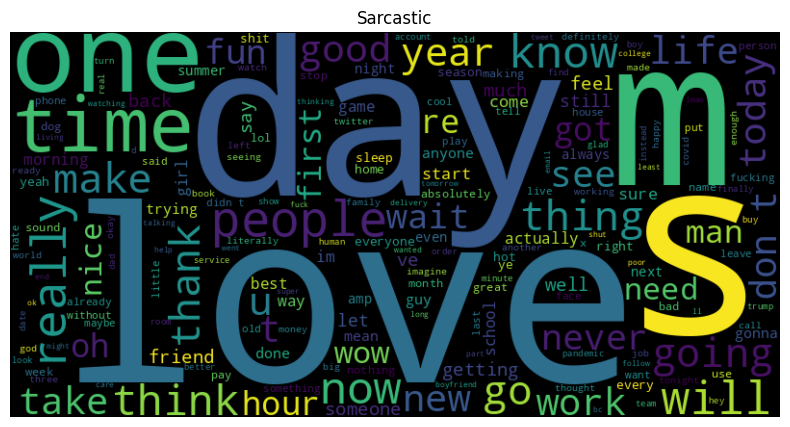

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
Sarcastic_text = ' '.join(
    df['tweet_clean'][df['sarcastic'] == 1].tolist())
wordcloud = WordCloud(width=800, height=400,
                      background_color='black').generate(Sarcastic_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Sarcastic')
plt.show()

- Visualization of the most redondant words in  non sarcastic text

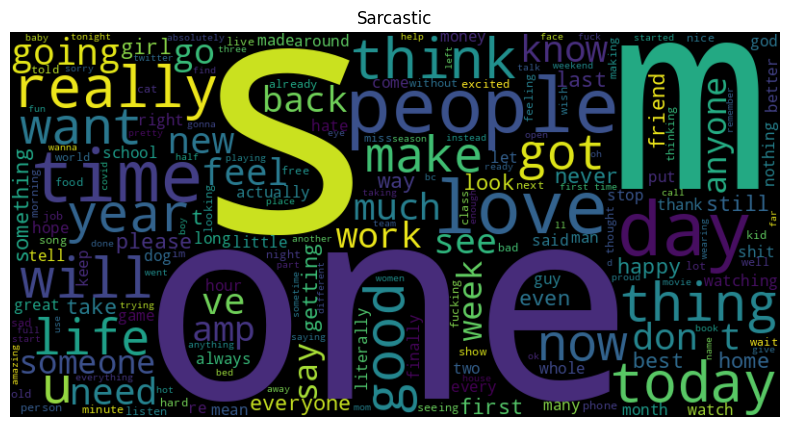

In [ ]:
Sarcastic_text = ' '.join(
    df['tweet_clean'][df['sarcastic'] == 0].tolist())
wordcloud = WordCloud(width=800, height=400,
                      background_color='black').generate(Sarcastic_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Sarcastic')
plt.show()

-- Splitting data into train and validation

In [ ]:
X = df['tweet_clean']
y = df['sarcastic']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"train set : {len(X_train)}")
print(f"val set : {len(X_val)}")
print(f"\nDistribution in train set :")
print(y_train.value_counts(normalize=True))
print(f"\nDistribution in val set :")
print(y_val.value_counts(normalize=True))

train set : 2774
val set : 694

Distribution in train set :
sarcastic
0    0.74982
1    0.25018
Name: proportion, dtype: float64

Distribution in val set :
sarcastic
0    0.75072
1    0.24928
Name: proportion, dtype: float64


- Tokenisation des données textuelles (préparation pour la vectorisation )

In [ ]:
tokenizer = TweetTokenizer(preserve_case=True, strip_handles=False, reduce_len=False)
def tokenize_tweet(text):
    return tokenizer.tokenize(text)

- Extraction des données à connotations sarcastiques et les additioner au données d' entrainement et de validation

In [ ]:
class SarcasmFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        for text in X:
            text = str(text)
            features.append([
                text.count('!'),
                text.count('?'),
                len(re.findall(r'[!?]+', text)),
                len([w for w in text.split() if w.isupper()])
            ])
        return np.array(features)
sarcasm_transformer = SarcasmFeatures()
features_array = sarcasm_transformer.transform(df['tweet_clean'])
features_df = pd.DataFrame(features_array, columns=['exclamations', 'questions', 'punct_groups', 'uppercase_words'])

df = pd.concat([df, features_df], axis=1)

df.head()


,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question,tweet_clean,exclamations,questions,punct_groups,uppercase_words
0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0,the only thing i got from college is a caffein...,0,0,0,0
1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0,i love it when professors draw a big question ...,0,0,0,0
2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0,remember the hundred emails from companies whe...,0,1,1,0
3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0,today my pop-pop told me i was not “forced” to...,0,0,0,0
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0,"i did too, and i also reported cancun cruz not...",0,0,0,0


> Testing ML models (linearRegression,SVC,RandomForrestClassifer,XGBoost ) and tuning their hyperparameters using GridSearchCV




In [ ]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
weight_dict = {cls: w for cls, w in zip(classes, class_weights)}
# Ratio for XGBoost (majority/ minority)
scale_pos_weight = class_weights[0] / class_weights[1] if len(class_weights) == 2 else 1.0

-- models List

In [ ]:
models = {
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
        "params": {
            "clf__C": [0.01, 0.1, 1,2,3, 10],
            "clf__solver": ['lbfgs'],
        }

    },
    "RandomForest": {
        "model": RandomForestClassifier(
            class_weight='balanced',
            n_jobs=-1,
            random_state=42
        ),
        "params": {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [10, 20, None],
            "clf__min_samples_split": [2, 5]
        }

    },
    "SVC": {
        "model": SVC(
            class_weight='balanced',
            cache_size=1000,
            random_state=42
        ),
        "params": {
            "clf__C": [0.1, 1,2,3, 10],
            "clf__kernel": ["linear","poly"],
            "clf__gamma": ['scale']
        }

    },
    "XGBoost": {
        "model": XGBClassifier(
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            n_jobs=-1,
            tree_method='hist',
            use_label_encoder=False,
            eval_metric='logloss'
        ),
        "params": {
            "clf__max_depth": [3, 5,7],
            "clf__learning_rate": [0.01,0.1, 0.2],
            "clf__n_estimators": [100, 200,300]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "clf__n_neighbors": [3, 5,7],
            "clf__weights": ['distance'],
            "clf__metric": ['euclidean','minkowski']
        }
    }
}

In [ ]:
def custom_f1_weighted(y_true, y_pred):
    f1_class1 = f1_score(y_true, y_pred, pos_label=1)
    f1_class0 = f1_score(y_true, y_pred, pos_label=0)
    return 0.9 * f1_class1 + 0.1 * f1_class0

custom_scorer = make_scorer(custom_f1_weighted, greater_is_better=True)

-- Vectorization using tf_idf+ Trying and tuning models  

In [ ]:
results = []

for name, mp in models.items():
    print(f"\n Running GridSearchCV for {name}...")

    # pipeline for vectorization
    pipeline = Pipeline([('features', FeatureUnion([
        ('tfidf', TfidfVectorizer(
            tokenizer=tokenize_tweet,
            ngram_range=(1, 2),
            max_features=8000,
            min_df=2
        )),
        ('sarcasm', Pipeline([
            ('extract', SarcasmFeatures())
        ]))
    ])),
        ('clf', mp["model"])
    ])
    # Application of Grid search for hyperparameter tuning

    search = GridSearchCV(
        pipeline,
        mp["params"],
        scoring=custom_scorer,
        refit=True,
        cv=5,
        verbose=1,
        n_jobs=-1
    )

    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    preds = best_model.predict(X_val)
    f1 = f1_score(y_val, preds)

    print(f" {name} done — Best F1: {f1:.4f}")
    print(classification_report(y_val, preds))

    results.append({
        "Model": name,
        "Best Params": search.best_params_,
        "F1 Score": f1
    })

results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)


 Running GridSearchCV for LogisticRegression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
 LogisticRegression done — Best F1: 0.3218
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       521
           1       0.32      0.32      0.32       173

    accuracy                           0.66       694
   macro avg       0.55      0.55      0.55       694
weighted avg       0.66      0.66      0.66       694


 Running GridSearchCV for RandomForest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
 RandomForest done — Best F1: 0.2671
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       521
           1       0.36      0.21      0.27       173

    accuracy                           0.71       694
   macro avg       0.56      0.54      0.54       694
weighted avg       0.67      0.71      0.68       694


 Running GridSearchCV for SVC...
Fitting 5 folds for

> Visualization models+gridSearch (tf_idf vectorizer)

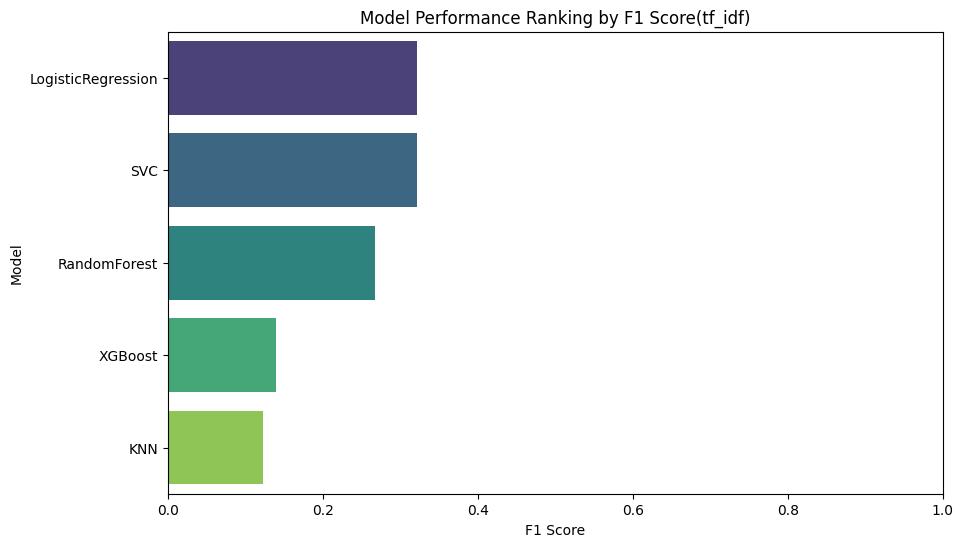

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.barplot(x="F1 Score", y="Model", data=results_df, palette="viridis")
plt.title("Model Performance Ranking by F1 Score(tf_idf)")
plt.xlabel("F1 Score")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.show()

- Vectorization using Bert  

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = BertModel.from_pretrained('bert-base-cased')
bert_model.eval()

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=128, padding=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy().flatten()

X_train_bert = np.array([get_bert_embedding(text) for text in X_train])
X_val_bert = np.array([get_bert_embedding(text) for text in X_val])

print(f"X_train_bert shape: {X_train_bert.shape}")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

X_train_bert shape: (2774, 768)


In [ ]:
smote_tomek = SMOTETomek(random_state=42)
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train_bert, y_train)

print(f"Original train shape: {X_train_bert.shape}")
print(f"Balanced train shape: {X_train_balanced.shape}")
print(f"\nBalanced distribution:\n{pd.Series(y_train_balanced).value_counts(normalize=True)}")

Original train shape: (2774, 768)
Balanced train shape: (4154, 768)

Balanced distribution:
sarcastic
1    0.5
0    0.5
Name: proportion, dtype: float64


- Testing ML models (linearRegression,SVC,RandomForrestClassifer,XGBoost ) and tuning their hyperparameters using GridSearchCV

In [ ]:
models = {
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
        "params": {
            "C": [0.1, 1,2,3, 10],
            "solver": ['lbfgs'],
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(
            class_weight='balanced',
            n_jobs=-1,
            random_state=42
        ),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [10, None],
            "min_samples_split": [2, 5]
        }
    },
    "SVC": {
        "model": SVC(
            class_weight='balanced',
            cache_size=500,
            random_state=42
        ),
        "params": {
            "C": [0.1, 1, 2,3,10],
            "kernel": ["linear","poly"],
            "gamma": ['scale']
        }
    },
    "XGBoost": {
        "model": XGBClassifier(
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            n_jobs=-1,
            tree_method='hist',
            use_label_encoder=False,
            eval_metric='logloss'
        ),
        "params": {
            "_max_depth": [3, 5,7],
            "learning_rate": [0.01,0.1, 0.2],
            "n_estimators": [100, 200,300]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5,7],
            "weights": ['distance'],
            "metric": ['euclidean','minkowski']
        }
    }
}

In [ ]:
results = []
best_models=[]

for name, mp in models.items():
    print(f"\n Running GridSearchCV for {name}...")
    print(f'{name} --{mp}')

    # Application of Grid search
    search = GridSearchCV(
        mp['model'],
        mp["params"],
        scoring=custom_scorer,
        refit=True,
        cv=5,
        verbose=1,
        n_jobs=-1
    )

    search.fit(X_train_balanced, y_train_balanced)
    best_model = search.best_estimator_
    best_models.append(best_model)
    preds = best_model.predict(X_val_bert)
    f1 = f1_score(y_val, preds)

    print(f" {name} done — Best F1: {f1:.4f}")
    print(classification_report(y_val, preds))

    results.append({
        "Model": name,
        "Best Params": search.best_params_,
        "F1 Score": f1
    })

results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)



 Running GridSearchCV for LogisticRegression...
LogisticRegression --{'model': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42), 'params': {'C': [0.1, 1, 2, 3, 10], 'solver': ['lbfgs']}}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
 LogisticRegression done — Best F1: 0.3593
              precision    recall  f1-score   support

           0       0.78      0.67      0.72       521
           1       0.30      0.44      0.36       173

    accuracy                           0.61       694
   macro avg       0.54      0.55      0.54       694
weighted avg       0.66      0.61      0.63       694


 Running GridSearchCV for RandomForest...
RandomForest --{'model': RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42), 'params': {'n_estimators': [100, 200], 'max_depth': [10, None], 'min_samples_split': [2, 5]}}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
 RandomForest done — Best F1: 0.1712
              preci

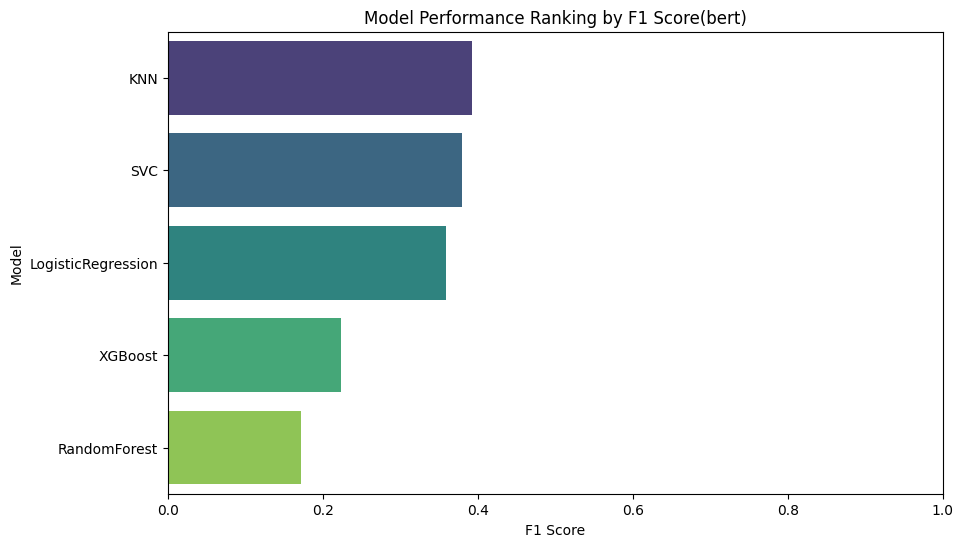

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x="F1 Score", y="Model", data=results_df, palette="viridis")
plt.title("Model Performance Ranking by F1 Score(bert)")
plt.xlabel("F1 Score")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.show()

- Using a stack of models working together to enhance performance

In [ ]:
stack = StackingClassifier(estimators=[
    ('lr', best_models[0]),
    ('rf', best_models[1]),
    ('svc',best_models[2])
], final_estimator=best_models[0])
stack.fit(X_train_balanced,y_train_balanced)
y_pred=stack.predict(X_val_bert)
print(classification_report(y_pred,y_val))

- Vectorisation avec RoBERTa

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base')
roberta_model.eval()
roberta_model.to(device)

def get_roberta_embedding_batch(texts, batch_size=32):
    embeddings = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]

        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            truncation=True,
            max_length=128,
            padding=True
        ).to(device)

        with torch.no_grad():
            outputs = roberta_model(**inputs)

        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

print("Extracting RoBERTa embeddings for training set...")
X_train_roberta = get_roberta_embedding_batch(X_train.tolist(), batch_size=32)

print("Extracting RoBERTa embeddings for test set...")
X_val_roberta = get_roberta_embedding_batch(X_val.tolist(), batch_size=32)

print(f"Train embeddings shape: {X_train_roberta.shape}")
print(f"Test embeddings shape: {X_val_roberta.shape}")

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Extracting RoBERTa embeddings for training set...


100%|██████████| 87/87 [00:10<00:00,  8.69it/s]


Extracting RoBERTa embeddings for test set...


100%|██████████| 22/22 [00:02<00:00,  8.94it/s]

Train embeddings shape: (2774, 768)
Test embeddings shape: (694, 768)


- Balancing classes using SMOTETomek

In [ ]:
smote_tomek = SMOTETomek(random_state=42)
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train_roberta, y_train)

print(f"Original train shape: {X_train_roberta.shape}")
print(f"Balanced train shape: {X_train_balanced.shape}")
print(f"\nBalanced distribution:\n{pd.Series(y_train_balanced).value_counts(normalize=True)}")

In [ ]:
results = []
best_models=[]
for name, mp in models.items():
    print(f"\n Running GridSearchCV for {name}...")
    print(f'{name} --{mp}')

    # Application of  Grid search
    search = GridSearchCV(
        mp['model'],
        mp["params"],
        scoring=custom_scorer,
        refit=True,
        cv=3,
        verbose=1,
        n_jobs=-1
    )

    search.fit(X_train_balanced, y_train_balanced)
    best_model = search.best_estimator_
    best_models.append(best_model)
    preds = best_model.predict(X_val_roberta)
    f1 = f1_score(y_val, preds)

    print(f" {name} done — Best F1: {f1:.4f}")
    print(classification_report(y_val, preds))

    results.append({
        "Model": name,
        "Best Params": search.best_params_,
        "F1 Score": f1
    })

results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)



 Running GridSearchCV for LogisticRegression...
LogisticRegression --{'model': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42), 'params': {'C': [0.1, 1, 2, 3, 10], 'solver': ['lbfgs']}}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
 LogisticRegression done — Best F1: 0.4399
              precision    recall  f1-score   support

           0       0.82      0.67      0.74       521
           1       0.36      0.56      0.44       173

    accuracy                           0.64       694
   macro avg       0.59      0.62      0.59       694
weighted avg       0.71      0.64      0.66       694


 Running GridSearchCV for RandomForest...
RandomForest --{'model': RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42), 'params': {'n_estimators': [100, 200], 'max_depth': [10, None], 'min_samples_split': [2, 5]}}
Fitting 3 folds for each of 8 candidates, totalling 24 fits
 RandomForest done — Best F1: 0.1165
              preci

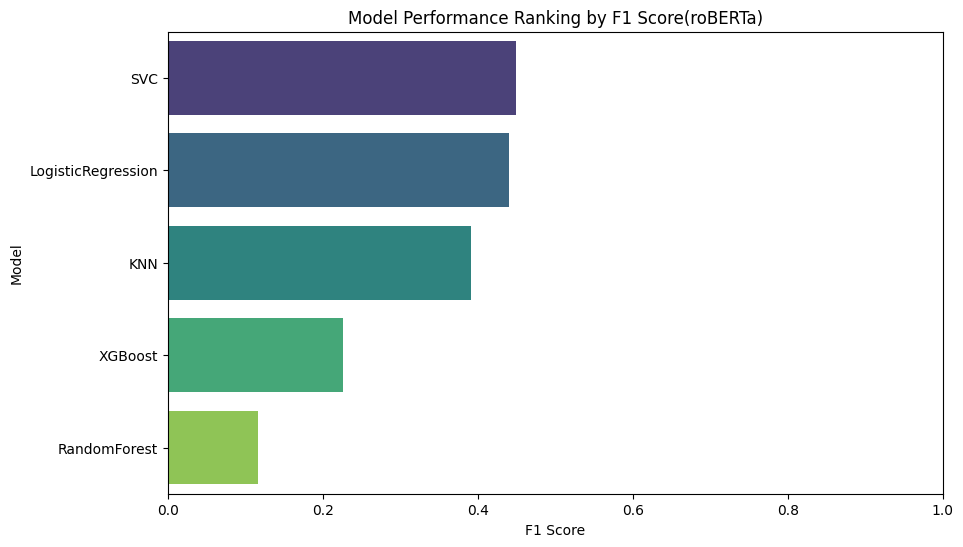

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x="F1 Score", y="Model", data=results_df, palette="viridis")
plt.title("Model Performance Ranking by F1 Score(roBERTa)")
plt.xlabel("F1 Score")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.show()

In [ ]:
from sklearn.ensemble import VotingClassifier
stack1 = VotingClassifier(estimators= [('lr', best_models[0]), ('rf', best_models[1]), ('svc', best_models[2])], voting='hard')
stack1.fit(X_train_balanced,y_train_balanced)
y_pred=stack1.predict(X_val_roberta)
print(classification_report(y_pred,y_val))

              precision    recall  f1-score   support

           0       0.71      0.83      0.76       449
           1       0.55      0.39      0.45       245

    accuracy                           0.67       694
   macro avg       0.63      0.61      0.61       694
weighted avg       0.65      0.67      0.66       694

